In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm

def detect_overlaps(call_data):
    """Detect overlapping speech segments between Agent and Customer.
    
    Args:
        call_data (list): List of speech segments with speaker, text, stime, and etime
        
    Returns:
        list: Detected overlap segments with timing information
    """
    # Separate agent and customer speech segments
    agent_segments = [entry for entry in call_data if entry['speaker'].lower() == 'agent']
    customer_segments = [entry for entry in call_data if entry['speaker'].lower() == 'customer']

    overlaps = []

    for a in agent_segments:
        for c in customer_segments:
            # Check if there is an overlap
            if (a['stime'] < c['etime']) and (a['etime'] > c['stime']):
                overlap_start = max(a['stime'], c['stime'])
                overlap_end = min(a['etime'], c['etime'])
                overlap_duration = overlap_end - overlap_start
                if overlap_duration > 0:
                    overlaps.append({
                        'overlap_start': overlap_start,
                        'overlap_end': overlap_end,
                        'overlap_duration': overlap_duration,
                        'agent_stime': a['stime'],
                        'agent_etime': a['etime'],
                        'customer_stime': c['stime'],
                        'customer_etime': c['etime'],
                        'initiator': 'Customer' if c['stime'] > a['stime'] else 'Agent'
                    })
    return overlaps

def save_data_to_csv(df, csv_path, description):
    """Save DataFrame to CSV file with proper notifications."""
    if csv_path:
        df.to_csv(csv_path, index=False)
        print(f"Saved {description} data to {csv_path}")

def plot_overlap_duration(overlaps, save_path=None, csv_path=None, show_plot=True):
    """Plot the duration of each overlapping speech segment over time.
    
    Args:
        overlaps (list): List of overlap dictionaries
        save_path (str, optional): Path to save the plot image
        csv_path (str, optional): Path to save the data as CSV
        show_plot (bool): Whether to display the plot
    """
    df = pd.DataFrame(overlaps)
    if df.empty:
        print("No overlaps to plot for duration.")
        return df
    
    # Save the raw data to CSV before any transformation
    if csv_path:
        # Select only the columns needed for the duration plot
        plot_data = df[['overlap_start', 'overlap_end', 'overlap_duration']]
        save_data_to_csv(plot_data, csv_path, "overlap duration")

    plt.figure(figsize=(10, 6))
    plt.bar(df['overlap_start'], df['overlap_duration'], width=0.5, color='purple', alpha=0.7)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Overlap Duration (seconds)')
    plt.title('Overlapping Speech Duration Between Agent and Customer Over Time')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved overlap duration plot to {save_path}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return df

def plot_overlap_frequency(overlaps, call_end_time, interval=5, save_path=None, csv_path=None, show_plot=True):
    """Plot the frequency of overlapping speech occurrences across time intervals.
    
    Args:
        overlaps (list): List of overlap dictionaries
        call_end_time (float): End time of the call in seconds
        interval (int): Size of time bins in seconds
        save_path (str, optional): Path to save the plot image
        csv_path (str, optional): Path to save the data as CSV
        show_plot (bool): Whether to display the plot
    """
    df = pd.DataFrame(overlaps)
    if df.empty:
        print("No overlaps to plot for frequency.")
        return None

    bins = list(range(0, int(call_end_time) + interval, interval))
    df['time_bin'] = pd.cut(df['overlap_start'], bins=bins, right=False)
    overlap_counts = df.groupby('time_bin').size().reset_index(name='overlap_count')
    
    # Save the frequency data to CSV
    if csv_path:
        # Convert the time_bin to string for better CSV compatibility
        overlap_counts_csv = overlap_counts.copy()
        overlap_counts_csv['time_bin'] = overlap_counts_csv['time_bin'].astype(str)
        save_data_to_csv(overlap_counts_csv, csv_path, "overlap frequency")

    plt.figure(figsize=(10, 6))
    plt.bar(overlap_counts['time_bin'].astype(str), overlap_counts['overlap_count'], color='teal', alpha=0.7)
    plt.xlabel('Time Interval (seconds)')
    plt.ylabel('Number of Overlapping Speech Occurrences')
    plt.title(f'Count of Overlapping Speech Occurrences per {interval}-Second Interval')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved overlap frequency plot to {save_path}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return overlap_counts

def plot_initiator_distribution(overlaps, save_path=None, csv_path=None, show_plot=True):
    """Plot a pie chart showing who typically initiates the overlaps.
    
    Args:
        overlaps (list): List of overlap dictionaries
        save_path (str, optional): Path to save the plot image
        csv_path (str, optional): Path to save the data as CSV
        show_plot (bool): Whether to display the plot
    """
    df = pd.DataFrame(overlaps)
    if df.empty:
        print("No overlaps to plot for initiator distribution.")
        return None

    initiator_counts = df['initiator'].value_counts().reset_index()
    initiator_counts.columns = ['initiator', 'count']
    
    # Save the initiator distribution data to CSV
    if csv_path:
        save_data_to_csv(initiator_counts, csv_path, "initiator distribution")

    plt.figure(figsize=(8, 6))
    plt.pie(initiator_counts['count'], labels=initiator_counts['initiator'], autopct='%1.1f%%', 
            colors=['lightblue', 'lightcoral'], startangle=90)
    plt.title('Distribution of Overlap Initiators')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved initiator distribution plot to {save_path}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return initiator_counts

def process_single_file(filepath, save_plots=False, save_csv=False, output_dir=None, show_plots=True, interval=5):
    """Process a single JSON call log file and visualize overlaps.
    
    Args:
        filepath (str): Path to JSON file
        save_plots (bool): Whether to save plot images
        save_csv (bool): Whether to save data as CSV files
        output_dir (str, optional): Directory to save plots and CSV files
        show_plots (bool): Whether to display plots
        interval (int): Size of time bins in seconds for frequency plot
        
    Returns:
        dict: Summary statistics about the overlaps
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            call_data = json.load(f)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

    overlaps = detect_overlaps(call_data)
    
    # Save raw overlap data to CSV
    if save_csv and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        base_filename = os.path.splitext(os.path.basename(filepath))[0]
        raw_overlap_csv = os.path.join(output_dir, f"{base_filename}_raw_overlaps.csv")
        
        # Create DataFrame from overlaps and save
        df_overlaps = pd.DataFrame(overlaps)
        if not df_overlaps.empty:
            save_data_to_csv(df_overlaps, raw_overlap_csv, "raw overlap")
    
    # Calculate summary statistics
    stats = {
        'file': os.path.basename(filepath),
        'total_overlaps': len(overlaps),
        'total_overlap_duration': sum(o['overlap_duration'] for o in overlaps) if overlaps else 0,
        'max_overlap_duration': max(o['overlap_duration'] for o in overlaps) if overlaps else 0,
        'avg_overlap_duration': sum(o['overlap_duration'] for o in overlaps) / len(overlaps) if overlaps else 0
    }

    # Determine call end time
    try:
        call_end_time = max(entry['etime'] for entry in call_data)
    except ValueError:
        call_end_time = 0
    
    # Set up file paths for saving plots and CSV data
    base_filename = os.path.splitext(os.path.basename(filepath))[0]
    
    if (save_plots or save_csv) and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        duration_plot_path = os.path.join(output_dir, f"{base_filename}_overlap_duration.png") if save_plots else None
        frequency_plot_path = os.path.join(output_dir, f"{base_filename}_overlap_frequency.png") if save_plots else None
        initiator_plot_path = os.path.join(output_dir, f"{base_filename}_initiator_distribution.png") if save_plots else None
        
        duration_csv_path = os.path.join(output_dir, f"{base_filename}_overlap_duration.csv") if save_csv else None
        frequency_csv_path = os.path.join(output_dir, f"{base_filename}_overlap_frequency.csv") if save_csv else None
        initiator_csv_path = os.path.join(output_dir, f"{base_filename}_initiator_distribution.csv") if save_csv else None
    else:
        duration_plot_path = None
        frequency_plot_path = None
        initiator_plot_path = None
        duration_csv_path = None
        frequency_csv_path = None
        initiator_csv_path = None

    # Generate plots and save corresponding data
    plot_overlap_duration(overlaps, save_path=duration_plot_path, csv_path=duration_csv_path, show_plot=show_plots)
    plot_overlap_frequency(overlaps, call_end_time, interval=interval, 
                          save_path=frequency_plot_path, csv_path=frequency_csv_path, show_plot=show_plots)
    
    if overlaps:
        plot_initiator_distribution(overlaps, save_path=initiator_plot_path, 
                                  csv_path=initiator_csv_path, show_plot=show_plots)
    
    return stats

def process_directory(directory_path, save_plots=False, save_csv=False, output_dir=None, show_plots=False, interval=5):
    """Process all JSON files in a directory and visualize overlaps.
    
    Args:
        directory_path (str): Path to directory containing JSON files
        save_plots (bool): Whether to save plot images
        save_csv (bool): Whether to save data as CSV files
        output_dir (str, optional): Directory to save plots and CSV files
        show_plots (bool): Whether to display plots
        interval (int): Size of time bins in seconds for frequency plot
        
    Returns:
        pandas.DataFrame: Summary statistics for all processed files
    """
    json_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.json')]
    print(f"Found {len(json_files)} JSON files to process")
    
    all_stats = []
    all_overlaps = []
    
    for filepath in tqdm(json_files, desc="Processing files"):
        file_id = os.path.basename(filepath)
        
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                call_data = json.load(f)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue
            
        # Detect overlaps for this file
        overlaps = detect_overlaps(call_data)
        
        # Add file ID to each overlap record for consolidated data
        for overlap in overlaps:
            overlap['file_id'] = file_id
        
        # Add to master list of all overlaps across files
        all_overlaps.extend(overlaps)
        
        # Process file for statistics and visualizations
        stats = process_single_file(filepath, save_plots=save_plots, save_csv=save_csv, 
                                  output_dir=output_dir, show_plots=show_plots, interval=interval)
        if stats:
            all_stats.append(stats)
    
    # Create and save consolidated DataFrames
    if save_csv and output_dir:
        # Save all overlaps across all files
        all_overlaps_df = pd.DataFrame(all_overlaps)
        if not all_overlaps_df.empty:
            consolidated_csv_path = os.path.join(output_dir, "all_overlaps_consolidated.csv")
            save_data_to_csv(all_overlaps_df, consolidated_csv_path, "consolidated overlap")
    
    # Compile and return summary statistics
    stats_df = pd.DataFrame(all_stats)
    
    if output_dir:
        if save_plots:
            # Generate aggregate plots across all files
            plot_aggregate_stats(stats_df, output_dir=output_dir, save_csv=save_csv, show_plots=show_plots)
        
        if save_csv:
            # Save summary statistics
            stats_csv_path = os.path.join(output_dir, "overlap_statistics.csv")
            save_data_to_csv(stats_df, stats_csv_path, "overlap statistics")
    
    return stats_df

def plot_aggregate_stats(stats_df, output_dir=None, save_csv=False, show_plots=True):
    """Generate aggregate statistics plots across all processed files.
    
    Args:
        stats_df (pandas.DataFrame): DataFrame with summary statistics
        output_dir (str, optional): Directory to save plots
        save_csv (bool): Whether to save data as CSV files
        show_plots (bool): Whether to display plots
    """
    if stats_df.empty:
        print("No statistics available to plot.")
        return
    
    # Plot total overlaps by file
    plt.figure(figsize=(12, 6))
    plt.bar(stats_df['file'], stats_df['total_overlaps'], color='blue', alpha=0.7)
    plt.xlabel('File')
    plt.ylabel('Total Overlaps')
    plt.title('Total Overlapping Speech Occurrences by File')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    if output_dir:
        if save_csv:
            # Save total overlaps data
            total_overlaps_csv = os.path.join(output_dir, "total_overlaps_by_file.csv")
            total_overlaps_df = stats_df[['file', 'total_overlaps']]
            save_data_to_csv(total_overlaps_df, total_overlaps_csv, "total overlaps by file")
        
        plt.savefig(os.path.join(output_dir, "total_overlaps_by_file.png"), 
                   dpi=300, bbox_inches='tight')
    
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    # Plot average overlap duration by file
    plt.figure(figsize=(12, 6))
    plt.bar(stats_df['file'], stats_df['avg_overlap_duration'], color='green', alpha=0.7)
    plt.xlabel('File')
    plt.ylabel('Average Overlap Duration (seconds)')
    plt.title('Average Overlapping Speech Duration by File')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    if output_dir:
        if save_csv:
            # Save average duration data
            avg_duration_csv = os.path.join(output_dir, "avg_overlap_duration_by_file.csv")
            avg_duration_df = stats_df[['file', 'avg_overlap_duration']]
            save_data_to_csv(avg_duration_df, avg_duration_csv, "average overlap duration by file")
        
        plt.savefig(os.path.join(output_dir, "avg_overlap_duration_by_file.png"), 
                   dpi=300, bbox_inches='tight')
    
    if show_plots:
        plt.show()
    else:
        plt.close()

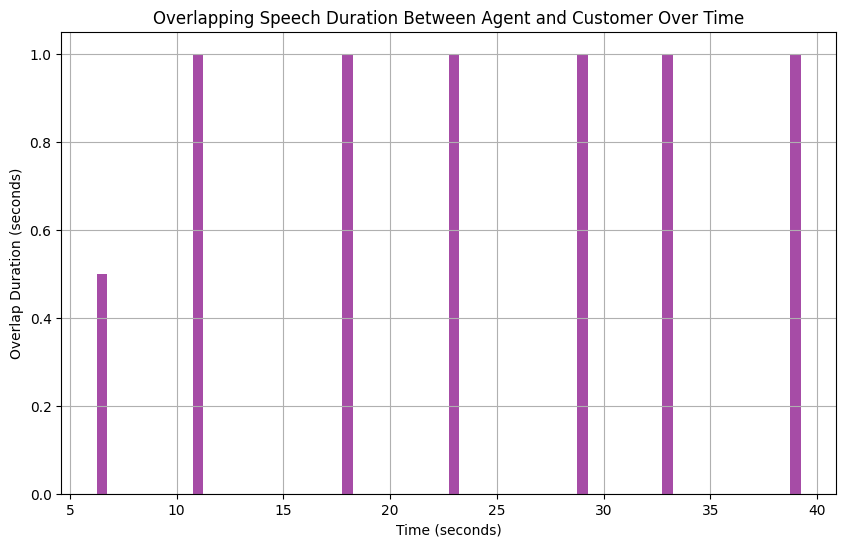

/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_68325/669075765.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overlap_counts = df.groupby('time_bin').size().reset_index(name='overlap_count')


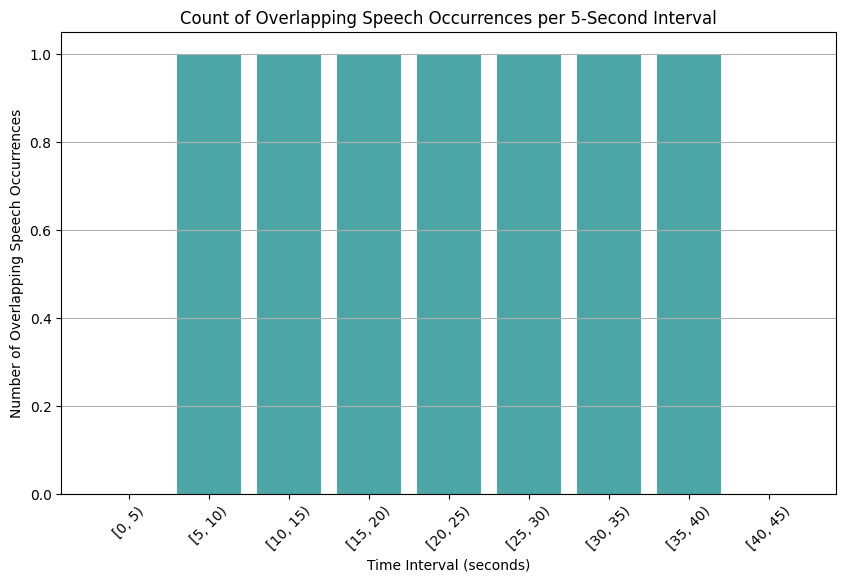

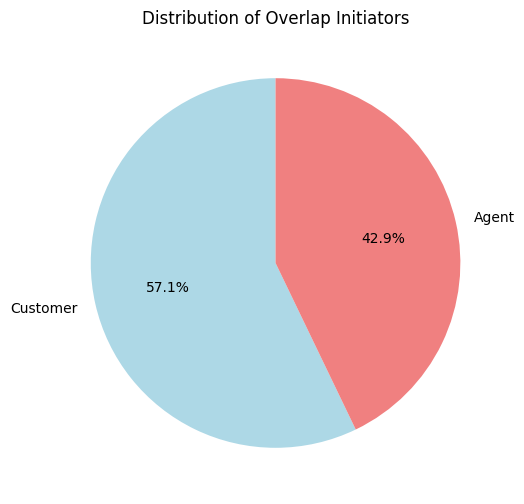

{'file': '00be25b0-458f-4cbf-ae86-ae2ec1f7fba4.json',
 'total_overlaps': 7,
 'total_overlap_duration': 6.5,
 'max_overlap_duration': 1,
 'avg_overlap_duration': 0.9285714285714286}

In [12]:
process_single_file("../All_Conversations/00be25b0-458f-4cbf-ae86-ae2ec1f7fba4.json", save_csv=True)

In [ ]:
process_directory("../All_Conversations", save_plots=True, output_dir="./temp_plots/", show_plots=False, interval=5, save_csv=True)

Found 250 JSON files to process


Processing files:   0%|          | 0/250 [00:00<?, ?it/s]

Saved raw overlap data to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_raw_overlaps.csv
Saved overlap duration data to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_overlap_duration.csv
Saved overlap duration plot to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_overlap_duration.png
Saved overlap frequency data to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_overlap_frequency.csv


/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_74848/1569027289.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overlap_counts = df.groupby('time_bin').size().reset_index(name='overlap_count')
Processing files:   0%|          | 1/250 [00:00<01:10,  3.55it/s]

Saved overlap frequency plot to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_overlap_frequency.png
Saved initiator distribution data to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_initiator_distribution.csv
Saved initiator distribution plot to ./temp_plots/2db2965e-54fa-41fa-823b-ed79b943f0b1_initiator_distribution.png
Saved raw overlap data to ./temp_plots/8a9655a7-be88-4921-b0ad-04aa1b9953d1_raw_overlaps.csv
Saved overlap duration data to ./temp_plots/8a9655a7-be88-4921-b0ad-04aa1b9953d1_overlap_duration.csv
Saved overlap duration plot to ./temp_plots/8a9655a7-be88-4921-b0ad-04aa1b9953d1_overlap_duration.png
Saved overlap frequency data to ./temp_plots/8a9655a7-be88-4921-b0ad-04aa1b9953d1_overlap_frequency.csv


/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_74848/1569027289.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overlap_counts = df.groupby('time_bin').size().reset_index(name='overlap_count')
Processing files:   1%|          | 2/250 [00:00<01:04,  3.87it/s]